# RWPE + nRWPE Concatenation on ZINC-12k with GINEConv

This notebook demonstrates the experiment testing **RWPE+nRWPE concatenation** vs **RWPE-only baseline** on ZINC-12k with GINEConv.

**Key concepts:**
- **RWPE (Random Walk Positional Encoding):** diag of (D⁻¹A)^t for t=1..k — captures linear random walk return probabilities
- **nRWPE (Nonlinear RWPE):** iterated tanh(Â·X) — captures nonlinear walk patterns
- **Concatenation:** RWPE ∥ nRWPE — combines both encoding types

**PE configurations tested:**
| Config | RWPE-k | nRWPE-k | Total PE dim |
|--------|--------|---------|-------------|
| rwpe_16 (baseline) | 16 | 0 | 16 |
| concat_16 | 8 | 8 | 16 |
| concat_24 | 16 | 8 | 24 |
| concat_32 | 16 | 16 | 32 |
| nrwpe_tanh_16 | 0 | 16 | 16 |
| no_pe | 0 | 0 | 16 (zeros) |

In [1]:
# ── Install dependencies ──────────────────────────────────────────
import subprocess, sys

def _pip_install(*pkgs):
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", *pkgs])

_IN_COLAB = "google.colab" in sys.modules

# Step 1: Install torch first (needed as build dependency for extensions)
_pip_install("torch", "--index-url", "https://download.pytorch.org/whl/cpu")

# Step 2: Install PyG extensions using pre-built wheels (avoids torch build dep issue)
import torch
torch_version = torch.__version__.split('+')[0]  # e.g. "2.5.1"
_pip_install(
    "torch-scatter", "torch-sparse",
    "-f", f"https://data.pyg.org/whl/torch-{torch_version}+cpu.html"
)

# Step 3: Install remaining packages
_pip_install("torch-geometric", "scipy", "psutil", "loguru")

# Colab pre-installed packages → only install outside Colab
if not _IN_COLAB:
    _pip_install("numpy", "matplotlib")

print("All dependencies installed.")

All dependencies installed.


In [2]:
# ── Imports ────────────────────────────────────────────────────────
import os
os.environ["OMP_NUM_THREADS"] = "1"

import json
import gc
import math
import time
import warnings
from pathlib import Path

import numpy as np
import scipy.sparse as sp
import scipy.stats as stats
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GINEConv, global_add_pool, global_mean_pool
from torch_geometric.loader import DataLoader

import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
print(f"PyTorch: {torch.__version__}, CUDA: {torch.cuda.is_available()}")

PyTorch: 2.7.1+cu126, CUDA: False


In [3]:
# ── Data loading helper ────────────────────────────────────────────
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/ai-invention-e02dcd-breaking-the-spectral-invariance-ceiling/main/experiment_iter6_rwpe_nrwpe_conc/demo/mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("mini_demo_data.json"):
        with open("mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
examples = data["datasets"][0]["examples"]
precomputed_analysis = data.get("precomputed_analysis", {})
print(f"Loaded {len(examples)} examples")
folds = {}
for ex in examples:
    folds[ex["metadata_fold"]] = folds.get(ex["metadata_fold"], 0) + 1
print(f"Folds: {folds}")

Loaded 60 examples
Folds: {'train': 40, 'val': 10, 'test': 10}


## Configuration

All tunable hyperparameters are defined here. The demo uses reduced values for fast execution; original values are shown in comments.

In [5]:
# ── Config ─────────────────────────────────────────────────────────
# Model architecture
HIDDEN_DIM = 32         # Original: 128
NUM_LAYERS = 2          # Original: 4
ATOM_EMB_DIM = 16       # Original: 64
DROPOUT = 0.1

# Training
BATCH_SIZE = 16         # Original: 128
LR = 1e-3
ETA_MIN = 1e-5
MAX_EPOCHS = 5          # Original: 150
T_MAX = 5               # Original: 150
PATIENCE = 5            # Original: 30
GRAD_CLIP = 5.0
SEEDS = [42]            # Original: [42, 123, 456]

# PE configurations to test in this demo
DEMO_PE_CONFIGS = {
    "rwpe_16":   {"rwpe_k": 16, "nrwpe_k": 0,  "mild_k": 0,  "pe_dim": 16},
    "concat_16": {"rwpe_k": 8,  "nrwpe_k": 8,  "mild_k": 0,  "pe_dim": 16},
    "no_pe":     {"rwpe_k": 0,  "nrwpe_k": 0,  "mild_k": 0,  "pe_dim": 16},
}

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE}")

Device: cpu


## Graph Parsing and PE Computation

Parse ZINC-12k molecular graphs and compute three types of positional encodings:
- **RWPE**: Standard random walk PE — diagonal of (D⁻¹A)^t
- **nRWPE**: Nonlinear variant — iterated tanh(Â·X) with symmetric normalization + self-loops
- **Mild nRWPE**: Residual variant — X + 0.1·tanh(Â·X)

In [6]:
# ── Graph parsing ──────────────────────────────────────────────────
def parse_graph(example: dict) -> dict:
    """Parse a single example into graph components."""
    inp = json.loads(example["input"])
    return {
        "edge_index": inp["edge_index"],
        "node_feat": inp["node_feat"],
        "edge_attr": inp["edge_attr"],
        "num_nodes": inp["num_nodes"],
        "y": float(example["output"]),
        "fold": example["metadata_fold"],
        "row_index": example.get("metadata_row_index", -1),
    }

graphs = []
for i, ex in enumerate(examples):
    try:
        g = parse_graph(ex)
        graphs.append(g)
    except Exception as e:
        print(f"Failed to parse graph {i}: {e}")

# Split by fold
train_graphs = [g for g in graphs if g["fold"] == "train"]
val_graphs = [g for g in graphs if g["fold"] == "val"]
test_graphs = [g for g in graphs if g["fold"] == "test"]
print(f"Parsed {len(graphs)} graphs: train={len(train_graphs)}, val={len(val_graphs)}, test={len(test_graphs)}")

Parsed 60 graphs: train=40, val=10, test=10


In [7]:
# ── PE computation functions ───────────────────────────────────────
def compute_rwpe(edge_index: list, n: int, k: int) -> np.ndarray:
    """Standard RWPE: diag of (D^{-1}A)^t for t=1..k. NO self-loops."""
    if n == 0 or k == 0:
        return np.zeros((max(n, 1), k), dtype=np.float32)

    row = np.array(edge_index[0], dtype=np.int32)
    col = np.array(edge_index[1], dtype=np.int32)
    data = np.ones(len(row), dtype=np.float32)
    A = sp.csr_matrix((data, (row, col)), shape=(n, n))

    deg = np.array(A.sum(axis=1)).flatten()
    deg_inv = np.where(deg > 0, 1.0 / deg, 0.0).astype(np.float32)
    D_inv = sp.diags(deg_inv)
    RW = D_inv @ A

    pe = np.zeros((n, k), dtype=np.float32)
    P = RW.copy()
    for t in range(k):
        pe[:, t] = P.diagonal()
        if t < k - 1:
            P = P @ RW
    return pe


def compute_nrwpe_tanh(edge_index: list, n: int, k: int) -> np.ndarray:
    """nRWPE: diag of iterated tanh(A_norm @ X). WITH self-loops, symmetric norm."""
    if n == 0 or k == 0:
        return np.zeros((max(n, 1), k), dtype=np.float32)

    row = np.array(edge_index[0], dtype=np.int32)
    col = np.array(edge_index[1], dtype=np.int32)
    data = np.ones(len(row), dtype=np.float32)
    A = sp.csr_matrix((data, (row, col)), shape=(n, n))

    A = A + sp.eye(n, dtype=np.float32)
    deg = np.array(A.sum(axis=1)).flatten()
    deg_inv_sqrt = np.where(deg > 0, 1.0 / np.sqrt(deg), 0.0).astype(np.float32)
    D_inv_sqrt = sp.diags(deg_inv_sqrt)
    A_norm_dense = (D_inv_sqrt @ A @ D_inv_sqrt).toarray()

    X = np.eye(n, dtype=np.float32)
    pe = np.zeros((n, k), dtype=np.float32)
    for t in range(k):
        X = np.tanh(A_norm_dense @ X)
        pe[:, t] = np.diag(X)
    return pe


def compute_all_pes_for_graph(idx, edge_index, n, max_rwpe_k, max_nrwpe_k):
    """Compute all PE types for a single graph."""
    result = {"idx": idx}
    if max_rwpe_k > 0:
        result["rwpe"] = compute_rwpe(edge_index, n, max_rwpe_k)
    if max_nrwpe_k > 0:
        result["nrwpe"] = compute_nrwpe_tanh(edge_index, n, max_nrwpe_k)
    return result


# Compute PEs for all graphs
print("Computing positional encodings...")
t0 = time.time()
max_rwpe_k = 16
max_nrwpe_k = 16

def compute_pes_for_split(graph_list):
    results = []
    for i, g in enumerate(graph_list):
        res = compute_all_pes_for_graph(i, g["edge_index"], g["num_nodes"], max_rwpe_k, max_nrwpe_k)
        results.append(res)
    return results

pe_results_train = compute_pes_for_split(train_graphs)
pe_results_val = compute_pes_for_split(val_graphs)
pe_results_test = compute_pes_for_split(test_graphs)
print(f"PE computation done in {time.time() - t0:.1f}s")

# Sanity check
sample = pe_results_train[0]
print(f"  RWPE shape: {sample['rwpe'].shape}, range: [{sample['rwpe'].min():.4f}, {sample['rwpe'].max():.4f}]")
print(f"  nRWPE shape: {sample['nrwpe'].shape}, range: [{sample['nrwpe'].min():.4f}, {sample['nrwpe'].max():.4f}]")

Computing positional encodings...


PE computation done in 1.7s
  RWPE shape: (9, 16), range: [0.0000, 0.8333]
  nRWPE shape: (9, 16), range: [0.0722, 0.4621]


## PE Tensor Construction and PyG Data

Build normalized PE tensors per config and convert to PyTorch Geometric `Data` objects for GINEConv training.

In [8]:
# ── PE tensor building & PyG data ──────────────────────────────────
def build_pe_tensor(pe_results: list, config: dict, train_stats: dict = None) -> tuple:
    """Build PE tensors for a given config, with optional z-score normalization."""
    rwpe_k = config["rwpe_k"]
    nrwpe_k = config["nrwpe_k"]
    mild_k = config.get("mild_k", 0)
    pe_dim = config["pe_dim"]

    pe_list = []
    for res in pe_results:
        parts = []
        if rwpe_k > 0:
            parts.append(res["rwpe"][:, :rwpe_k])
        if nrwpe_k > 0:
            parts.append(res["nrwpe"][:, :nrwpe_k])

        if len(parts) > 0:
            pe = np.concatenate(parts, axis=1)
        else:
            n = res.get("rwpe", res.get("nrwpe", np.zeros((1, 1)))).shape[0]
            pe = np.zeros((n, pe_dim), dtype=np.float32)
        pe_list.append(pe)

    # Compute or apply z-score normalization
    if train_stats is None:
        all_pe = np.concatenate(pe_list, axis=0)
        mean = all_pe.mean(axis=0)
        std = all_pe.std(axis=0)
        std = np.where(std < 1e-8, 1.0, std)
        train_stats = {"mean": mean, "std": std}

    for i in range(len(pe_list)):
        pe_list[i] = (pe_list[i] - train_stats["mean"]) / train_stats["std"]

    return pe_list, train_stats


def build_pyg_data(graphs: list, pe_list: list, pe_dim: int) -> list:
    """Convert graphs + PEs to PyG Data objects."""
    data_list = []
    for g, pe in zip(graphs, pe_list):
        edge_index = torch.tensor(g["edge_index"], dtype=torch.long)
        x = torch.tensor(g["node_feat"], dtype=torch.long)
        edge_attr = torch.tensor(g["edge_attr"], dtype=torch.long)
        y = torch.tensor([g["y"]], dtype=torch.float32)
        pe_tensor = torch.tensor(pe, dtype=torch.float32)
        d = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y, pe=pe_tensor)
        data_list.append(d)
    return data_list

print("PE tensor building functions defined.")

PE tensor building functions defined.


## GINEConv Model

A 4-layer GINEConv GNN with:
- Atom embedding + optional PE projection
- GINEConv message passing with edge features
- Dual readout: global_add_pool + global_mean_pool → MLP → scalar MAE prediction

In [9]:
# ── Model definition ───────────────────────────────────────────────
class GINEConvZINC(nn.Module):
    def __init__(self, pe_dim: int = 16, hidden_dim: int = 128, num_layers: int = 4,
                 atom_emb_dim: int = 64, dropout: float = 0.1, use_pe: bool = True):
        super().__init__()
        self.use_pe = use_pe
        self.atom_emb = nn.Embedding(28, atom_emb_dim)
        self.bond_emb = nn.Embedding(4, hidden_dim)

        if use_pe:
            self.pe_proj = nn.Sequential(
                nn.Linear(pe_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(hidden_dim, atom_emb_dim),
            )
            self.pe_bn = nn.BatchNorm1d(atom_emb_dim)
            self.input_proj = nn.Linear(atom_emb_dim + atom_emb_dim, hidden_dim)
        else:
            self.input_proj = nn.Linear(atom_emb_dim, hidden_dim)

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        for _ in range(num_layers):
            mlp = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
            )
            conv = GINEConv(mlp, edge_dim=hidden_dim)
            self.convs.append(conv)
            self.bns.append(nn.BatchNorm1d(hidden_dim))

        self.readout = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, data):
        x = self.atom_emb(data.x)
        if self.use_pe:
            pe = self.pe_bn(self.pe_proj(data.pe))
            x = self.input_proj(torch.cat([x, pe], dim=-1))
        else:
            x = self.input_proj(x)

        edge_attr = self.bond_emb(data.edge_attr)
        for conv, bn in zip(self.convs, self.bns):
            x = F.relu(bn(conv(x, data.edge_index, edge_attr)))

        x_add = global_add_pool(x, data.batch)
        x_mean = global_mean_pool(x, data.batch)
        x = torch.cat([x_add, x_mean], dim=-1)
        return self.readout(x).squeeze(-1)

print("GINEConvZINC model defined.")

GINEConvZINC model defined.

## Training Loop

Train each PE configuration, evaluate on validation and test sets, and collect results.

In [10]:
# ── Training functions ─────────────────────────────────────────────
def set_seed(seed: int):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0
    total_count = 0
    for batch in loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        pred = model(batch)
        loss = F.l1_loss(pred, batch.y.squeeze(-1))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        optimizer.step()
        total_loss += loss.item() * batch.num_graphs
        total_count += batch.num_graphs
    return total_loss / total_count


@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    total_count = 0
    all_preds, all_targets = [], []
    for batch in loader:
        batch = batch.to(device)
        pred = model(batch)
        targets = batch.y.squeeze(-1)
        loss = F.l1_loss(pred, targets, reduction='sum')
        total_loss += loss.item()
        total_count += batch.num_graphs
        all_preds.extend(pred.cpu().numpy().tolist())
        all_targets.extend(targets.cpu().numpy().tolist())
    mae = total_loss / total_count
    return mae, all_preds, all_targets


def run_single_config(config_name, config, train_data, val_data, test_data,
                      pe_results_train, pe_results_val, pe_results_test,
                      seed, device):
    """Train and evaluate a single configuration with a single seed."""
    set_seed(seed)
    pe_dim = config["pe_dim"]
    use_pe = config_name != "no_pe"

    pe_train, train_stats = build_pe_tensor(pe_results_train, config)
    pe_val, _ = build_pe_tensor(pe_results_val, config, train_stats)
    pe_test, _ = build_pe_tensor(pe_results_test, config, train_stats)

    train_dataset = build_pyg_data(train_data, pe_train, pe_dim)
    val_dataset = build_pyg_data(val_data, pe_val, pe_dim)
    test_dataset = build_pyg_data(test_data, pe_test, pe_dim)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

    model = GINEConvZINC(
        pe_dim=pe_dim, hidden_dim=HIDDEN_DIM, num_layers=NUM_LAYERS,
        atom_emb_dim=ATOM_EMB_DIM, dropout=DROPOUT, use_pe=use_pe
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = CosineAnnealingLR(optimizer, T_max=T_MAX, eta_min=ETA_MIN)

    best_val_mae = float('inf')
    best_epoch = 0
    patience_counter = 0
    best_state = None

    for epoch in range(1, MAX_EPOCHS + 1):
        train_mae = train_one_epoch(model, train_loader, optimizer, device)
        val_mae, _, _ = evaluate(model, val_loader, device)
        scheduler.step()

        if val_mae < best_val_mae:
            best_val_mae = val_mae
            best_epoch = epoch
            patience_counter = 0
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            patience_counter += 1

        if epoch % max(1, MAX_EPOCHS // 5) == 0 or epoch == 1:
            print(f"  [{config_name}|s{seed}] Epoch {epoch}: train={train_mae:.4f} val={val_mae:.4f} best={best_val_mae:.4f}@{best_epoch}")

        if patience_counter >= PATIENCE:
            print(f"  [{config_name}|s{seed}] Early stopping at epoch {epoch}")
            break

    model.load_state_dict(best_state)
    model.to(device)
    test_mae, test_preds, test_targets = evaluate(model, test_loader, device)
    val_mae_final, _, _ = evaluate(model, val_loader, device)

    num_params = sum(p.numel() for p in model.parameters())
    print(f"  [{config_name}|s{seed}] DONE: test_mae={test_mae:.4f}, val_mae={val_mae_final:.4f}, params={num_params}")

    del model, optimizer, scheduler
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    return {
        "config_name": config_name, "seed": seed,
        "test_mae": test_mae, "val_mae": val_mae_final,
        "best_epoch": best_epoch, "num_params": num_params,
        "test_preds": test_preds, "test_targets": test_targets,
    }

print("Training functions defined.")

Training functions defined.


In [11]:
# ── Run training for each PE config ────────────────────────────────
print("=" * 60)
print("Training all PE configurations")
print("=" * 60)

all_results = {}
t_start = time.time()

for config_name, config in DEMO_PE_CONFIGS.items():
    print(f"\n--- Config: {config_name} (pe_dim={config['pe_dim']}) ---")
    all_results[config_name] = []

    for seed in SEEDS:
        result = run_single_config(
            config_name, config,
            train_graphs, val_graphs, test_graphs,
            pe_results_train, pe_results_val, pe_results_test,
            seed=seed, device=DEVICE
        )
        all_results[config_name].append(result)

total_time = time.time() - t_start
print(f"\nTotal training time: {total_time:.1f}s")

Training all PE configurations

--- Config: rwpe_16 (pe_dim=16) ---


  [rwpe_16|s42] Epoch 1: train=1.7182 val=1.4485 best=1.4485@1


  [rwpe_16|s42] Epoch 2: train=1.3305 val=1.3998 best=1.3998@2


  [rwpe_16|s42] Epoch 3: train=1.3094 val=1.3415 best=1.3415@3


  [rwpe_16|s42] Epoch 4: train=1.1856 val=1.3248 best=1.3248@4


  [rwpe_16|s42] Epoch 5: train=1.1593 val=1.2547 best=1.2547@5


  [rwpe_16|s42] DONE: test_mae=1.7942, val_mae=1.2547, params=11441

--- Config: concat_16 (pe_dim=16) ---


  [concat_16|s42] Epoch 1: train=1.5927 val=1.4946 best=1.4946@1


  [concat_16|s42] Epoch 2: train=1.2158 val=1.4235 best=1.4235@2


  [concat_16|s42] Epoch 3: train=1.2771 val=1.4164 best=1.4164@3


  [concat_16|s42] Epoch 4: train=0.9834 val=1.3680 best=1.3680@4


  [concat_16|s42] Epoch 5: train=1.2617 val=1.3038 best=1.3038@5


  [concat_16|s42] DONE: test_mae=1.7944, val_mae=1.3038, params=11441

--- Config: no_pe (pe_dim=16) ---


  [no_pe|s42] Epoch 1: train=1.6631 val=1.5649 best=1.5649@1


  [no_pe|s42] Epoch 2: train=1.1171 val=1.3714 best=1.3714@2


  [no_pe|s42] Epoch 3: train=1.0040 val=1.1077 best=1.1077@3


  [no_pe|s42] Epoch 4: train=0.8639 val=0.9998 best=0.9998@4


  [no_pe|s42] Epoch 5: train=0.8188 val=0.9168 best=0.9168@5


  [no_pe|s42] DONE: test_mae=1.4599, val_mae=0.9168, params=9825



Total training time: 262.1s


## Results Summary

Print demo results and compare with the full experiment's pre-computed results (ZINC-12k, 3 seeds, 150 epochs).

In [12]:
# ── Results summary ────────────────────────────────────────────────
print("=" * 72)
print(f"{'Config':<18} {'Test MAE':>12} {'Val MAE':>12} {'Best Ep':>10} {'Params':>10}")
print("-" * 72)
for config_name, seed_results in all_results.items():
    test_maes = [r["test_mae"] for r in seed_results]
    val_maes = [r["val_mae"] for r in seed_results]
    best_eps = [r["best_epoch"] for r in seed_results]
    print(
        f"{config_name:<18} "
        f"{np.mean(test_maes):.4f}+/-{np.std(test_maes):.4f}  "
        f"{np.mean(val_maes):.4f}+/-{np.std(val_maes):.4f}  "
        f"{np.mean(best_eps):>8.1f}  "
        f"{seed_results[0]['num_params']:>10d}"
    )
print("=" * 72)

# Show pre-computed full results
print("\n--- Full experiment results (pre-computed, 12k graphs, 150 epochs, 3 seeds) ---")
print(f"{'Config':<18} {'Test MAE':>18} {'Params':>10}")
print("-" * 52)
for cname in ["rwpe_16", "concat_32", "concat_24", "concat_16", "nrwpe_tanh_16", "no_pe", "mild_16"]:
    if cname in precomputed_analysis:
        a = precomputed_analysis[cname]
        print(f"{cname:<18} {a['test_mae_mean']:.4f}+/-{a['test_mae_std']:.4f}       {a['num_params']:>10d}")
print("=" * 52)

Config                 Test MAE      Val MAE    Best Ep     Params
------------------------------------------------------------------------
rwpe_16            1.7942+/-0.0000  1.2547+/-0.0000       5.0       11441
concat_16          1.7944+/-0.0000  1.3038+/-0.0000       5.0       11441
no_pe              1.4599+/-0.0000  0.9168+/-0.0000       5.0        9825

--- Full experiment results (pre-computed, 12k graphs, 150 epochs, 3 seeds) ---
Config                       Test MAE     Params
----------------------------------------------------
rwpe_16            0.1011+/-0.0020           262593
concat_32          0.1062+/-0.0017           264641
concat_24          0.1072+/-0.0028           263617
concat_16          0.1069+/-0.0018           262593
nrwpe_tanh_16      0.1201+/-0.0008           262593
no_pe              0.1930+/-0.0037           243841
mild_16            0.1819+/-0.0016           262593


## Visualization

Compare PE configurations using the full pre-computed results. Key finding: RWPE-16 baseline outperforms all concatenation variants — GINEConv message passing may already capture nonlinear walk information.

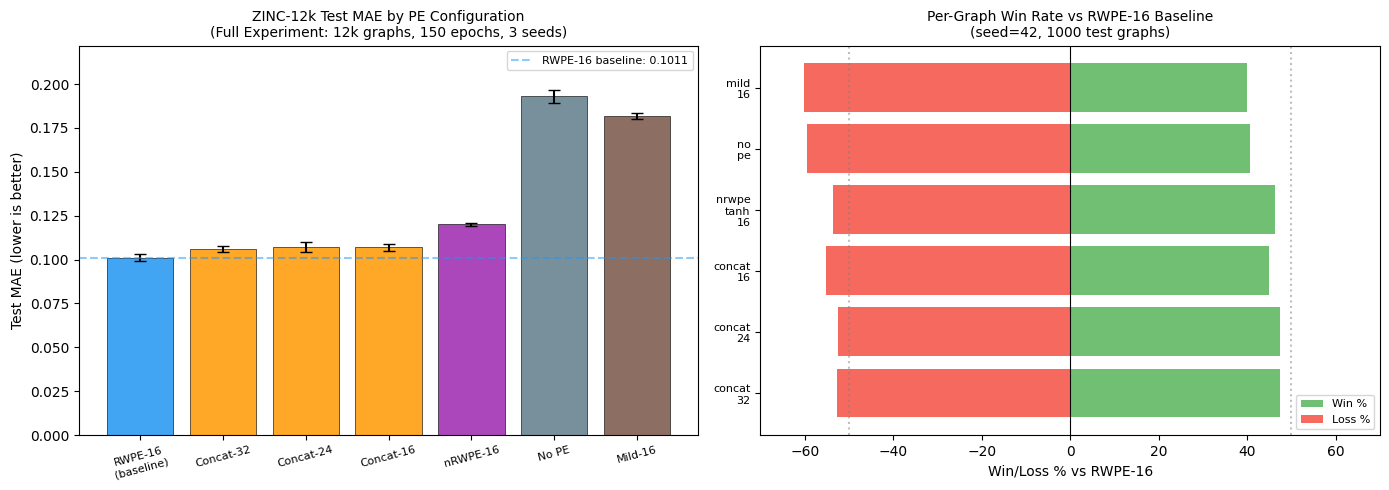

Visualization saved to results_visualization.png


In [13]:
# ── Visualization ──────────────────────────────────────────────────
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Plot 1: Bar chart of Test MAE (full pre-computed results) ---
config_order = ["rwpe_16", "concat_32", "concat_24", "concat_16", "nrwpe_tanh_16", "no_pe", "mild_16"]
config_labels = ["RWPE-16\n(baseline)", "Concat-32", "Concat-24", "Concat-16", "nRWPE-16", "No PE", "Mild-16"]
colors = ["#2196F3", "#FF9800", "#FF9800", "#FF9800", "#9C27B0", "#607D8B", "#795548"]

means = []
stds = []
for cname in config_order:
    if cname in precomputed_analysis:
        means.append(precomputed_analysis[cname]["test_mae_mean"])
        stds.append(precomputed_analysis[cname]["test_mae_std"])
    else:
        means.append(0)
        stds.append(0)

ax = axes[0]
bars = ax.bar(range(len(config_order)), means, yerr=stds, capsize=4, color=colors, edgecolor='black', linewidth=0.5, alpha=0.85)
ax.set_xticks(range(len(config_order)))
ax.set_xticklabels(config_labels, fontsize=8, rotation=15)
ax.set_ylabel("Test MAE (lower is better)", fontsize=10)
ax.set_title("ZINC-12k Test MAE by PE Configuration\n(Full Experiment: 12k graphs, 150 epochs, 3 seeds)", fontsize=10)
ax.axhline(y=means[0], color='#2196F3', linestyle='--', alpha=0.5, label=f"RWPE-16 baseline: {means[0]:.4f}")
ax.legend(fontsize=8)
ax.set_ylim(0, max(means) * 1.15)

# --- Plot 2: Win rate vs RWPE-16 ---
ax2 = axes[1]
wr_configs = []
wr_wins = []
wr_losses = []
wr_labels = []
for cname in ["concat_32", "concat_24", "concat_16", "nrwpe_tanh_16", "no_pe", "mild_16"]:
    if cname in precomputed_analysis and "win_rate_vs_rwpe16" in precomputed_analysis[cname]:
        wr = precomputed_analysis[cname]["win_rate_vs_rwpe16"]
        wr_configs.append(cname)
        wr_wins.append(wr["win_pct"])
        wr_losses.append(100 - wr["win_pct"])
        wr_labels.append(cname.replace("_", "\n"))

x = range(len(wr_configs))
ax2.barh(x, wr_wins, color='#4CAF50', alpha=0.8, label='Win %')
ax2.barh(x, [-l for l in wr_losses], color='#F44336', alpha=0.8, label='Loss %')
ax2.set_yticks(x)
ax2.set_yticklabels(wr_labels, fontsize=8)
ax2.set_xlabel("Win/Loss % vs RWPE-16", fontsize=10)
ax2.set_title("Per-Graph Win Rate vs RWPE-16 Baseline\n(seed=42, 1000 test graphs)", fontsize=10)
ax2.axvline(x=0, color='black', linewidth=0.8)
ax2.axvline(x=50, color='gray', linestyle=':', alpha=0.5)
ax2.axvline(x=-50, color='gray', linestyle=':', alpha=0.5)
ax2.set_xlim(-70, 70)
ax2.legend(fontsize=8, loc='lower right')

plt.tight_layout()
plt.savefig("results_visualization.png", dpi=100, bbox_inches='tight')
plt.show()
print("Visualization saved to results_visualization.png")